# test consistency code


In [ ]:
import cobra as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import copy as cp
from IPython.display import clear_output

# Load Models

m1 = cb.io.load_matlab_model('AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

M = [m1, m2]


# Define Media

# AGORA Format
media = {
    'EX_o2(e)': 0, #aerobic/anaerobic
    'EX_h2o(e)': -1000,
    'EX_pi(e)': -1000,
    'EX_fe2(e)': -1000,
    'EX_fe3(e)': -1000,
    'EX_zn2(e)': -1000,
    'EX_so4(e)': -1000,
    'EX_cu2(e)': -1000,
    'EX_k(e)': -1000,
    'EX_mg2(e)': -1000,
    'EX_mn2(e)': -1000,
    'EX_cd2(e)': -1000,
    'EX_cl(e)': -1000,
    'EX_ca2(e)': -1000,
    'EX_cobalt2(e)': -1000,
    'EX_glc_D(e)': -10,
    'EX_nh4(e)': -20,

    'EX_ribflv(e)': -1000,
    'EX_pnto_R(e)': -1000,
    'EX_nac(e)': -1000,
    'EX_his_L(e)': -1000,
    'EX_asn_L(e)': -1000,
    'EX_glycys(e)': -1000,

    'EX_lys_L(e)': -1000,
    'EX_ala_L(e)': -1000,
    'EX_met_L(e)': -1000,
    'EX_leu_L(e)': -1000,
    'EX_hxan(e)': -1000,    
    'EX_ser_L(e)': -1,
}

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [ ]:


# Dynamic Simulation (run through 1 time step split int m_n substeps)
def dynamic_simulation(max_substeps, step_size, models, rel_abund, media, EX):
    # count total unique exchange reactions in all models
    N = len(EX)
    dvdt = np.zeros(N)

    results = np.zeros((N, max_substeps, len(models)))
    sum_results = np.zeros((N, max_substeps, len(models)))
    vs = np.zeros((N, max_substeps))

    # initialize state vector
    v = np.zeros(N)
    # update media with media fluxes
    dvdt = np.zeros(N)
    for e, flux in media.items():
        ind = EX.index(e)
        dvdt[ind] = -1*flux
    # update state vector with media fluxes
    v = v + dvdt

    # update media with model fluxes
    # loop max_substeps times to smooth dynamics
    for step in range(max_substeps):
        clear_output(wait=False)
        print('Step ' + str(step) + ' of ' + str(max_substeps))

        vs[:,step] = v #keep track of state vector over time

        v_tmp = v
        for i in range(len(models)):
            dvdt = np.zeros(N)

            m = models[i]
            rel_abund_i = rel_abund[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of v available to be fluxed
                    flux_lim = v[ind]/rel_abund_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            sol = m.optimize()

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol.fluxes[exch.id]
                ind = EX.index(e)
                dvdt[ind] = (flux*rel_abund_i)*step_size

                results[ind, step, i] = flux
                sum_results[ind, step, i] = dvdt[ind]

            # update state vector with model fluxes
            v_tmp = v_tmp + dvdt
        
        v = v_tmp

    return results, sum_results, vs



In [ ]:
def consist_check(max_substeps, step_size, models, rel_abund, media, EX):
    # count total unique exchange reactions in all models
    N_exs = len(EX)
    dvdt = np.zeros(N_exs)

    # flux_results = np.zeros((N_exs, max_substeps, len(models)))
    flux_v_results = np.zeros((N_exs,max_substeps, len(models)))
    vs = np.zeros((N_exs, max_substeps+1))

    # initialize state vector
    v = np.zeros(N_exs)
    # update media with media fluxes
    dvdt = np.zeros(N_exs)
    for e, flux in media.items():
        ind = EX.index(e)
        dvdt[ind] = -1*flux
    # update state vector with media fluxes
    v = v + dvdt

    # update media with model fluxes
    # loop max_substeps times to smooth dynamics
    for step in range(max_substeps):
        clear_output(wait=False)
        print('Step ' + str(step) + ' of ' + str(max_substeps))

        vs[:, step] = v #keep track of state vector over time

        v_tmp = v # mmol/ (gt * hr)
        for i in range(len(models)):
            dvdt = np.zeros(N_exs)

            m = models[i]
            rel_abund_i = rel_abund[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of v available to be fluxed
                    flux_lim = v[ind]/rel_abund_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            sol = m.optimize()

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol.fluxes[exch.id] # internal fluxes
                if flux > 0:
                    ind = EX.index(e)
                    dvdt[ind] = (flux*rel_abund_i)*step_size # mmol / (gt * hr^2) # flux velocity = conc accel

                # flux_results[ind, step, i] = flux
                flux_v_results[ind, step, i] = dvdt[ind]

            # update state vector with model fluxes
            v_tmp = v_tmp + dvdt
        
        # consistency check
        if np.all(np.abs(v_tmp - v) < 1e-6 ):
            print("Negative concentrations detected, stopping simulation")
            v = v_tmp
            break
        v = v_tmp

    vs[:, max_substeps] = v
    return flux_v_results, vs


Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [ ]:
# Simulation
rel_abund = [0.5, 0.5]
max_substeps = 400
step_size = 0.01

EX = []
for m in M:
    for exch in m.exchanges:
        EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N_exs = len(EX)
v0 = np.zeros(N_exs)

models = cp.deepcopy(M)

sum_results, xs = dynamic_simulation(max_substeps, step_size, models, rel_abund, media, EX)

Step 399 of 400


### consistency check v1 results

[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10

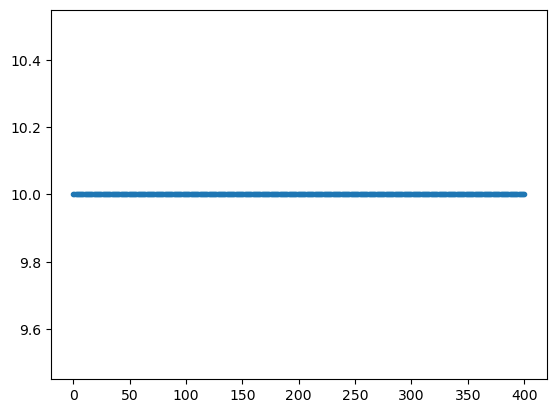

In [ ]:
i = EX.index('EX_glc_D(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[ 0.          0.17507812  0.35074097  0.52640383  0.70206669  0.87772954
  1.0533924   1.22905525  1.40471811  1.58038097  1.75604382  1.93170668
  2.10736954  2.28303239  2.45869525  2.63435811  2.81002096  2.98568382
  3.16134668  3.33700953  3.51267239  3.68833525  3.8639981   4.03966096
  4.21532382  4.39098667  4.56664953  4.74231238  4.91797524  5.0936381
  5.26930095  5.44496381  5.62062667  5.79628952  5.97195238  6.14761524
  6.32327809  6.49894095  6.67460381  6.85026666  7.02592952  7.20159238
  7.37725523  7.55291809  7.72858094  7.9042438   8.07990666  8.25556951
  8.43123237  8.60689523  8.78255808  8.95822094  9.1338838   9.30954665
  9.48520951  9.66087237  9.83653522 10.01219808 10.18786094 10.36352379
 10.53918665 10.71484951 10.89051236 11.06617522 11.24183807 11.41750093
 11.59316379 11.76882664 11.9444895  12.12015236 12.29581521 12.47147807
 12.64714093 12.82280378 12.99846664 13.1741295  13.34979235 13.52545521
 13.70111807 13.87678092 14.05244378 14.22810663 14.

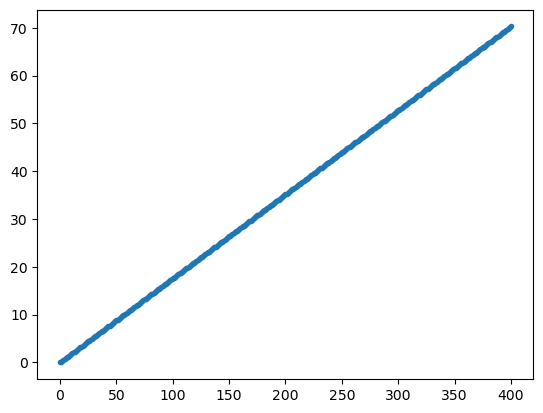

In [ ]:
i = EX.index('EX_lac_L(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

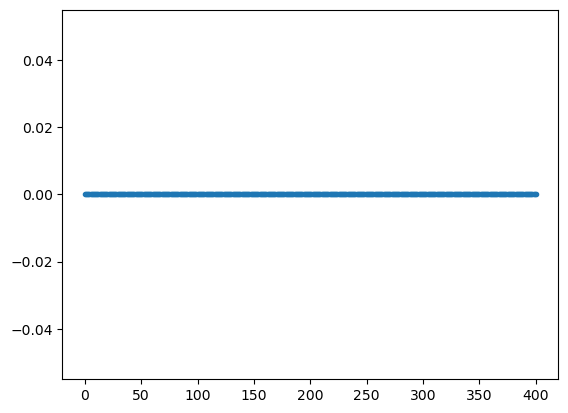

In [ ]:
i = EX.index('EX_ac(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[0.00000000e+00 8.44346789e-02 1.69638471e-01 2.55614052e-01
 3.42361423e-01 4.29880582e-01 5.18171531e-01 6.07234269e-01
 6.97068796e-01 7.87675112e-01 8.79053218e-01 9.71203112e-01
 1.06412480e+00 1.15781827e+00 1.25228353e+00 1.34752058e+00
 1.44352942e+00 1.54031005e+00 1.63786247e+00 1.73618668e+00
 1.83528268e+00 1.93515046e+00 2.03579004e+00 2.13720140e+00
 2.23938456e+00 2.34233950e+00 2.44606623e+00 2.55056475e+00
 2.65583507e+00 2.76187717e+00 2.86869105e+00 2.97627673e+00
 3.08463420e+00 3.19376346e+00 3.30366450e+00 3.41433734e+00
 3.52578196e+00 3.63799837e+00 3.75098658e+00 3.86474657e+00
 3.97927835e+00 4.09458192e+00 4.21065728e+00 4.32750443e+00
 4.44512336e+00 4.56351409e+00 4.68267661e+00 4.80261091e+00
 4.92332219e+00 5.04482809e+00 5.16712859e+00 5.29022371e+00
 5.41411344e+00 5.53879779e+00 5.66427674e+00 5.79055031e+00
 5.91761848e+00 6.04548127e+00 6.17413868e+00 6.30359069e+00
 6.43383732e+00 6.56487855e+00 6.69671440e+00 6.82934487e+00
 6.96276994e+00 7.096989

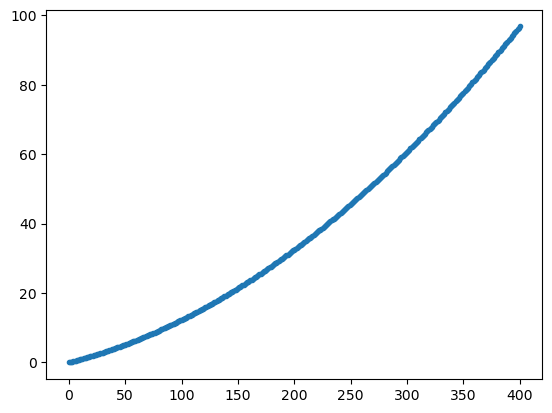

In [ ]:
i = EX.index('EX_but(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

# Try V2, consistency check (lagged uptake)


In [ ]:
import cobra as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import copy as cp
from IPython.display import clear_output

# Load Models

m1 = cb.io.load_matlab_model('AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

M = [m1, m2]


# Define Media

# AGORA Format
media = {
    'EX_o2(e)': 0, #aerobic/anaerobic
    'EX_h2o(e)': -1000,
    'EX_pi(e)': -1000,
    'EX_fe2(e)': -1000,
    'EX_fe3(e)': -1000,
    'EX_zn2(e)': -1000,
    'EX_so4(e)': -1000,
    'EX_cu2(e)': -1000,
    'EX_k(e)': -1000,
    'EX_mg2(e)': -1000,
    'EX_mn2(e)': -1000,
    'EX_cd2(e)': -1000,
    'EX_cl(e)': -1000,
    'EX_ca2(e)': -1000,
    'EX_cobalt2(e)': -1000,
    'EX_glc_D(e)': -10,
    'EX_nh4(e)': -20,

    'EX_ribflv(e)': -1000,
    'EX_pnto_R(e)': -1000,
    'EX_nac(e)': -1000,
    'EX_his_L(e)': -1000,
    'EX_asn_L(e)': -1000,
    'EX_glycys(e)': -1000,

    'EX_lys_L(e)': -1000,
    'EX_ala_L(e)': -1000,
    'EX_met_L(e)': -1000,
    'EX_leu_L(e)': -1000,
    'EX_hxan(e)': -1000,    
    'EX_ser_L(e)': -1,
}

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [ ]:
def consist_check(max_substeps, step_size, models, rel_abund, media, EX, lag_rate):
    # count total unique exchange reactions in all models
    N_exs = len(EX)
    dvdt = np.zeros(N_exs)
    step_stopped = max_substeps

    # flux_results = np.zeros((N_exs, max_substeps, len(models)))
    flux_v_results = np.zeros((N_exs,max_substeps, len(models)))
    vs = np.zeros((N_exs, max_substeps+1))
    uptakes = np.zeros((N_exs, max_substeps+lag_rate, len(models)))

    # initialize state vector
    v = np.zeros(N_exs)
    # update media with media fluxes
    dvdt = np.zeros(N_exs)
    for e, flux in media.items():
        ind = EX.index(e)
        dvdt[ind] = -1*flux
    # update state vector with media fluxes
    v = v + dvdt

    # update media with model fluxes
    # loop max_substeps times to smooth dynamics
    for step in range(max_substeps):
        clear_output(wait=False)
        print('Step ' + str(step) + ' of ' + str(max_substeps))
        try:
            print(sol.objective_value)

        except:
            print("No solution")

        vs[:, step] = v #keep track of state vector over time

        v_tmp = v # mmol/ (gt * hr)
        for i in range(len(models)):
            dvdt = np.zeros(N_exs)

            m = models[i]
            rel_abund_i = rel_abund[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of v available to be fluxed
                    flux_lim = v[ind]/rel_abund_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            try:
                sol = m.optimize()
            except:
                print("Done Growing")
                step_stopped = step
                v = v_tmp
                break

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol.fluxes[exch.id] # internal fluxes
                if flux > 0:
                    ind = EX.index(e)
                    dvdt[ind] = (flux*rel_abund_i)*step_size # mmol / (gt * hr^2) # flux velocity = conc accel
                
                elif flux < 0:
                    ind = EX.index(e)
                    uptake_ind = step + lag_rate
                    uptakes[ind, uptake_ind, i] = (flux*rel_abund_i)*step_size
                    dvdt[ind] = uptakes[ind, step, i] # use uptake from lag_rate steps ago
                # flux_results[ind, step, i] = flux
                flux_v_results[ind, step, i] = dvdt[ind]

            # update state vector with model fluxes
            v_tmp = v_tmp + dvdt
        
        # consistency check
        if np.all(np.abs(v_tmp - v) < 1e-6 ):
            print("Converged, stopping simulation")
            step_stopped = step
            v = v_tmp
            break
        v = v_tmp
    
    vs[:, step_stopped:] = np.tile(v, (max_substeps-step_stopped+1, 1)).T
    return flux_v_results, vs


In [ ]:
# Simulation
rel_abund = [0.5, 0.5]
max_substeps = 400
step_size = .01
lag_rate = 4

EX = []
for m in M:
    for exch in m.exchanges:
        EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N_exs = len(EX)
x0 = np.zeros(N_exs)

models = cp.deepcopy(M)

sum_results, xs = consist_check(max_substeps, step_size, models, rel_abund, media, EX, lag_rate)

Step 366 of 400
0.006914508869029836


KeyboardInterrupt: 

[10. 10. 10. 10. 10.  8.  6.  4.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0. 

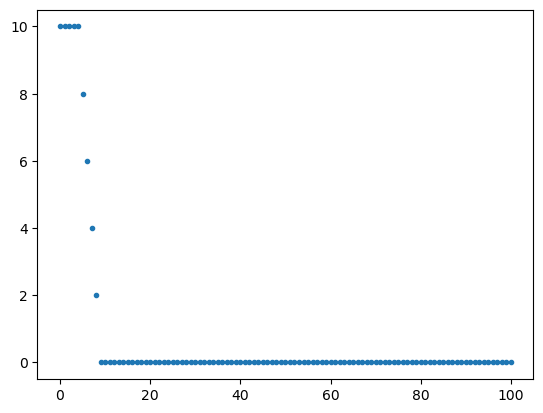

In [4]:
i = EX.index('EX_glc_D(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[ 0.          1.75078116  3.50740972  5.26403829  7.02066685  8.77729542
 10.00752016 10.71075632 10.88700392 10.53626295  9.6585334   8.65778139
  7.58670576  6.49800536  5.44437907  4.47852573  3.61274759  2.85407702
  2.20427648  1.65983857  1.211986    0.85071124  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354  0.56530354
  0.56530354  0.56530354  0.56530354  0.56530354  0

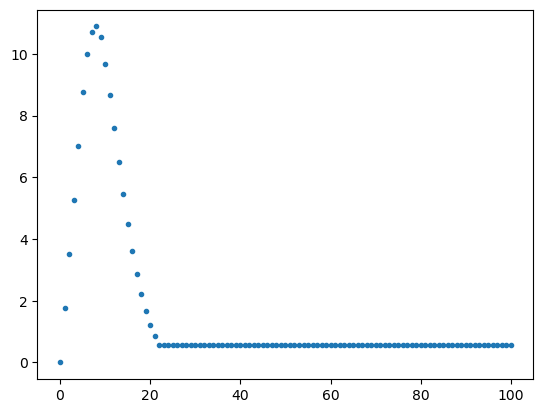

In [6]:
i = EX.index('EX_lac_L(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.

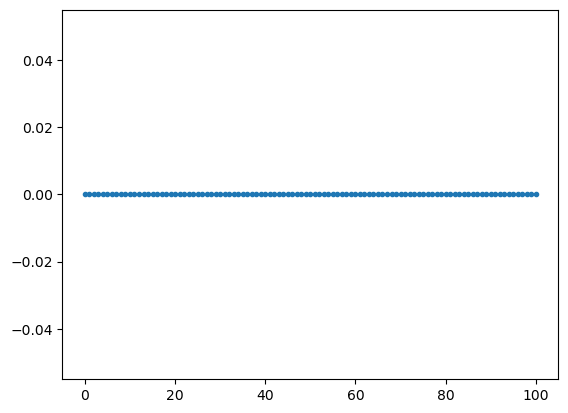

In [9]:
i = EX.index('EX_ac(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

[ 0.          0.84434679  1.7656049   2.76404192  3.83965786  4.99245272
  6.06076443  7.02232399  7.85329307  8.52983329  9.03544059  9.49678895
  9.90867557 10.2683159  10.5753436  10.83181057 11.0421427  11.21128617
 11.34446561 11.44694228 11.52377225 11.57752929 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456 11.61714456
 11.61714456 11.61714456 11.61714456 11.61714456 11

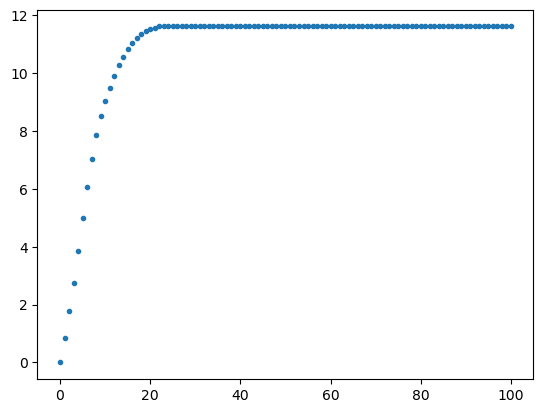

In [5]:
i = EX.index('EX_but(e)')
print(xs[i,:])
print(sum_results[i,:,:])
plt.plot(xs[i,:],'.')

# v3


In [ ]:
import cobra as cb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import copy as cp
from IPython.display import clear_output

# Load Models

m1 = cb.io.load_matlab_model('AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

M = [m1, m2]


# Define Media

# AGORA Format
media = {
    'EX_o2(e)': 0, #aerobic/anaerobic
    'EX_h2o(e)': -1000,
    'EX_pi(e)': -1000,
    'EX_fe2(e)': -1000,
    'EX_fe3(e)': -1000,
    'EX_zn2(e)': -1000,
    'EX_so4(e)': -1000,
    'EX_cu2(e)': -1000,
    'EX_k(e)': -1000,
    'EX_mg2(e)': -1000,
    'EX_mn2(e)': -1000,
    'EX_cd2(e)': -1000,
    'EX_cl(e)': -1000,
    'EX_ca2(e)': -1000,
    'EX_cobalt2(e)': -1000,
    'EX_glc_D(e)': -10,
    'EX_nh4(e)': -20,

    'EX_ribflv(e)': -1000,
    'EX_pnto_R(e)': -1000,
    'EX_nac(e)': -1000,
    'EX_his_L(e)': -1000,
    'EX_asn_L(e)': -1000,
    'EX_glycys(e)': -1000,

    'EX_lys_L(e)': -1000,
    'EX_ala_L(e)': -1000,
    'EX_met_L(e)': -1000,
    'EX_leu_L(e)': -1000,
    'EX_hxan(e)': -1000,    
    'EX_ser_L(e)': -1,
}

In [ ]:
def dynam_sim(max_substeps, step_size, models, rel_abund, media, EX, lag_rate):
    # count total unique exchange reactions in all models
    N_exs = len(EX)
    dvdt = np.zeros(N_exs)
    step_stopped = max_substeps

    # flux_results = np.zeros((N_exs, max_substeps, len(models)))
    flux_v_results = np.zeros((N_exs,max_substeps, len(models)))
    vs = np.zeros((N_exs, max_substeps+1))

    # initialize state vector
    v = np.zeros(N_exs)
    # update media with media fluxes
    dvdt = np.zeros(N_exs)
    for e, flux in media.items():
        ind = EX.index(e)
        dvdt[ind] = -1*flux
    # update state vector with media fluxes
    v = v + dvdt

    # update media with model fluxes
    # loop max_substeps times to smooth dynamics
    for step in range(max_substeps):
        clear_output(wait=False)
        print('Step ' + str(step) + ' of ' + str(max_substeps))
        try:
            print(sol_obj.objective_value)

        except:
            print("No solution")

        vs[:, step] = v #keep track of state vector over time

        v_tmp = v # mmol/ (gt * hr)
        for i in range(len(models)):
            dvdt = np.zeros(N_exs)

            m = models[i]
            rel_abund_i = rel_abund[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of v available to be fluxed
                    flux_lim = v[ind]/rel_abund_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            sol_fluxes, sol_obj = check_consistency(models, v, EX, 100)

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol_fluxes[exch.id] # internal fluxes
                ind = EX.index(e)
                dvdt[ind] = (flux*rel_abund_i)*step_size # mmol / (gt * hr^2) # flux velocity = conc accel

                # flux_results[ind, step, i] = flux
                flux_v_results[ind, step, i] = dvdt[ind]

            # update state vector with model fluxes
            v_tmp = v_tmp + dvdt
        
        # consistency check
        if np.all(np.abs(v_tmp - v) < 1e-6 ):
            print("Converged, stopping simulation")
            step_stopped = step
            v = v_tmp
            break
        v = v_tmp
    
    vs[:, step_stopped:] = np.tile(v, (max_substeps-step_stopped+1, 1)).T
    return flux_v_results, vs


def check_consistency(models, media, EX, max_iters_check, step_size):
     # count total unique exchange reactions in all models
    N_exs = len(EX)
    dvdt = np.zeros(N_exs)
    step_stopped = max_substeps

    models = cp.deepcopy(models)

    # flux_results = np.zeros((N_exs, max_substeps, len(models)))
    flux_v_results = np.full((N_exs,max_substeps, len(models)), np.nan)
    media_vs = np.full((N_exs, max_substeps+1), np.nan)

    for e, flux in media.items():
        ind = EX.index(e)
        dvdt[ind] = -1*flux
    media_vs[:,0] = dvdt

    for step in range(1, max_iters_check+1):
        clear_output(wait=False)
        print('Consistency Check Step ' + str(step) + ' of ' + str(max_iters_check))
        try:
            print(sol.objective_value)
        except:
            print("No solution")

        v_tmp = media_vs[:, step-1] # mmol/ (gt * hr)
        for i in range(len(models)):
            dvdt = np.zeros(N_exs)

            m = models[i]
            rel_abund_i = rel_abund[i]
            # turn off all exchanges
            for exch in m.exchanges:
                exch.lower_bound = 0
                exch.upper_bound = 1000

            # set model updtake constraints from media concentrations
            for ind, e in enumerate(EX):
                if e in m.exchanges:
                    # calculate amount of v available to be fluxed
                    flux_lim = media_vs[ind, step-1]/rel_abund_i
                    m.exchanges.get_by_id(e).lower_bound = -1*flux_lim
            
            # solve FBA
            sol = m.optimize()

            # update media with model fluxes
            for exch in m.exchanges:
                e, flux = exch.id, sol.fluxes[exch.id] # internal fluxes
                if flux > 0:
                    ind = EX.index(e)
                    dvdt[ind] = (flux*rel_abund_i)*step_size # mmol / (gt * hr^2) # flux velocity = conc accel
                elif flux < 0:
                    ind = EX.index(e)
                    dvdt[ind] = 0 # uptake not allowed in consistency check

                # flux_results[ind, step, i] = flux
                flux_v_results[ind, step, i] = dvdt[ind]

            # update state vector with model fluxes
            v_tmp = v_tmp + dvdt
        
        media_vs[:, step] = v_tmp

        # consistency check
        # check if 2-1 = 1-0 <- iter #, then it is linearly growing
        if np.all(np.abs(media_vs[:, step] - 2 *  media_vs[:, step-1] + media_vs[:, step-2]) < 1e-6 ):
            print("Converged, stopping simulation")
            step_stopped = step
            v = v_tmp
            break
        

    media_vs[:, step_stopped:] = np.tile(v, (max_substeps-step_stopped+1, 1)).T

    return flux_v_results, media_vs, 
# storage vars
# set media
# simulate
# sum across models
# update media
# check if 3-2 = 2-1
     

"""# Simulation
rel_abund = [0.5, 0.5]
max_substeps = 400
step_size = .01
lag_rate = 4

EX = []
for m in M:
    for exch in m.exchanges:
        EX.append(exch.id)
EX = list(dict.fromkeys(EX))
N_exs = len(EX)
x0 = np.zeros(N_exs)

models = cp.deepcopy(M)"""

### "Consistency Check" will not work
Consistency check being where before we update media, we check what happens if we only add secreted media, if there is no change then we keep 

In [1]:
import gifba
import cobra as cb

m1 = cb.io.load_matlab_model('AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

# AGORA Format
media = {
    'EX_o2(e)': 0, #aerobic/anaerobic
    'EX_h2o(e)': -1000,
    'EX_pi(e)': -1000,
    'EX_fe2(e)': -1000,
    'EX_fe3(e)': -1000,
    'EX_zn2(e)': -1000,
    'EX_so4(e)': -1000,
    'EX_cu2(e)': -1000,
    'EX_k(e)': -1000,
    'EX_mg2(e)': -1000,
    'EX_mn2(e)': -1000,
    'EX_cd2(e)': -1000,
    'EX_cl(e)': -1000,
    'EX_ca2(e)': -1000,
    'EX_cobalt2(e)': -1000,
    'EX_glc_D(e)': -10,
    'EX_nh4(e)': -20,

    'EX_ribflv(e)': -1000,
    'EX_pnto_R(e)': -1000,
    'EX_nac(e)': -1000,
    'EX_his_L(e)': -1000,
    'EX_asn_L(e)': -1000,
    'EX_glycys(e)': -1000,

    'EX_lys_L(e)': -1000,
    'EX_ala_L(e)': -1000,
    'EX_met_L(e)': -1000,
    'EX_leu_L(e)': -1000,
    'EX_hxan(e)': -1000,    
    'EX_ser_L(e)': -1,
}

Set parameter Username
Set parameter LicenseID to value 2684253
Academic license - for non-commercial use only - expires 2026-07-02


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [2]:
community_1 = gifba.gifbaObject([m1, m2], media, rel_abund="equal", step_size=0.01)
its=30
media_flux_1, org_flux_1, ratios = community_1.consist_check(iters=its, method="pfba", early_stop=True, v=False)


Read LP format model from file /tmp/tmp5nus9wly.lp
Reading time = 0.00 seconds
: 932 rows, 2064 columns, 8440 nonzeros
Read LP format model from file /tmp/tmpnazths_d.lp
Reading time = 0.00 seconds
: 980 rows, 2102 columns, 8980 nonzeros
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
Iteration  Run
0          0      1000.000000
1          0       999.992572
2          0       999.985260
3          0       999.978063
4          0       999.970980
5          0       999.964001
6          0       999.957125
7          0       999.950356
8          0       999.943686
9          0       999.937120
10         0       999.930649
11         0       999.924272
12         0       999.917993
13         0       999.911811
14         0       999.905718
15         0       999.899712
16         0         0.000000
17         0         0.000000
18         0         0.000000
19         0         0.000000
20         0         0.000000
21         0         0.000000
22         0         0.000000
23         0         0

/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:426: RuntimeWarning: divide by zero encountered in divide
  ratio_arr = (last_iter / (env_init-last_iter)).reshape(-1, 1).T
/home/rseag/UVM/M3_Lab/giFBA/package/gifba/gifba_object.py:426: RuntimeWarning: invalid value encountered in divide
  ratio_arr = (last_iter / (env_init-last_iter)).reshape(-1, 1).T


382


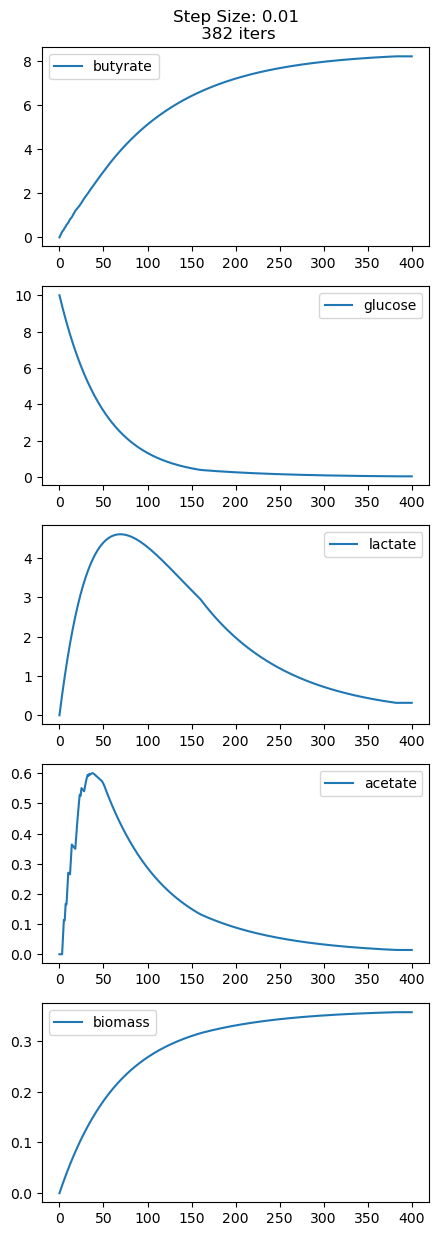

In [3]:
print(community_1.iter_converged)
import matplotlib.pyplot as plt
import numpy as np
# with community_001 as comm:
# 	plt.plot(comm.env_fluxes["EX_but(e)"], label='butyrate')
# 	plt.plot(comm.env_fluxes["EX_glc_D(e)"], label='glucose')
# 	plt.plot(comm.env_fluxes["EX_lac_L(e)"], label='lactate')
# 	plt.plot(comm.env_fluxes["EX_ac(e)"], label='acetate')
# 	plt.legend()

fig, ax = plt.subplots(5, 1, sharey='row', figsize=(5, 15))
for idx, (step_size, community) in enumerate(zip(
    [0.01],
    [community_1]
)):
    model_idx = 1
    # ax[0].plot(community.org_fluxes.loc[model_idx, "EX_but(e)"], label='butyrate')
    # # ax[0].set_xlim(-0.1 * community.iter_converged, community.iter_converged * 1.5)
    
    # ax[1].plot(community.org_fluxes.loc[model_idx, "EX_glc_D(e)"], label='glucose')
    # # ax[1].set_xlim(-0.1 * community.iter_converged, community.iter_converged * 1.5)

    # ax[2].plot(community.org_fluxes.loc[model_idx, "EX_lac_L(e)"], label='lactate')
    # # ax[2].set_xlim(-0.1 * community.iter_converged, community.iter_converged * 1.5)
    
    # ax[3].plot(community.org_fluxes.loc[model_idx, "EX_ac(e)"], label='acetate')
    # # ax[3].set_xlim(-0.1 * community.iter_converged, community.iter_converged * 1.5)
    
    # ax[4].plot(community.org_fluxes.loc[model_idx, "EX_biomass(e)"], label='biomass')
    # # ax[4].set_xlim(-0.1 * community.iter_converged, community.iter_converged * 1.5)
    
    ax[0].plot(community.env_fluxes["EX_but(e)"], label='butyrate')
    ax[1].plot(community.env_fluxes["EX_glc_D(e)"], label='glucose')
    ax[2].plot(community.env_fluxes["EX_lac_L(e)"], label='lactate')	
    ax[3].plot(community.env_fluxes["EX_ac(e)"], label='acetate')	
    ax[4].plot(community.env_fluxes["EX_biomass(e)"], label='biomass')
    
    ax[0].set_title(f'Step Size: {step_size}\n {community.iter_converged} iters')
    if idx == 0:
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        ax[3].legend()
        ax[4].legend()

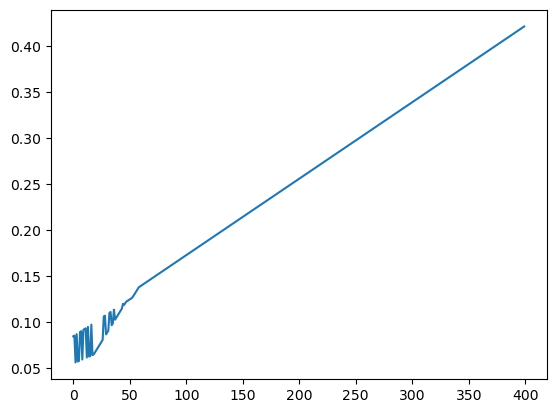

In [4]:
 # this undoing cumsum at end of sim 

# plt.plot(community_1.flux_tracker.loc[1, "EX_glc_D(e)"])
# plt.plot(np.diff(community_1.org_fluxes.loc[1, "EX_glc_D(e)"]))
plt.plot(np.diff(community_1.env_fluxes["EX_but(e)"])) 
# community_1.flux_tracker.loc[[1,0], "EX_glc_D(e)"]

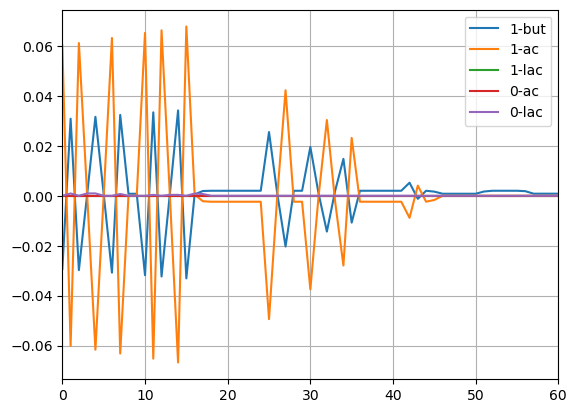

In [15]:
plt.plot(np.diff(np.diff(community_1.org_fluxes.loc[1, "EX_but(e)"])), label="1-but")
plt.plot(np.diff(np.diff(community_1.org_fluxes.loc[1, "EX_ac(e)"])), label="1-ac") 
plt.plot(np.diff(np.diff(community_1.org_fluxes.loc[1, "EX_lac_L(e)"])), label="1-lac") 
plt.plot(np.diff(np.diff(community_1.org_fluxes.loc[0, "EX_ac(e)"])), label="0-ac") 
plt.plot(np.diff(np.diff(community_1.org_fluxes.loc[0, "EX_lac_L(e)"])), label="0-lac") 
plt.grid()
plt.xlim(0, 60)
plt.legend()